In [142]:
import random
class Organism:
    def __init__(self, gene_type, probability_to_engage_w_opposite_characteristic):
        self.gene_type = gene_type
        self.prob_eng_same = 1 - probability_to_engage_w_opposite_characteristic
        self.prob_eng_opposite = probability_to_engage_w_opposite_characteristic
    
    def get_gene_type(self):
        return self.gene_type

    def get_prob_eng_opposite(self):
        return self.prob_eng_opposite

    def mating_decision(self, mate_gene_type):
        """function that determines whether organism wants to reproduce with a potential mate using probabiliti.
            If if does, returns true otherwise it return false """
        value = random.uniform(0,1)

        if mate_gene_type != self.gene_type:
            if value <= self.prob_eng_opposite:
                return True
            else:
                return False

        else:
            if value <= self.prob_eng_same:
                return True
            else:
                return False
            



    

In [184]:
import matplotlib.pyplot as plt
class Population:
    def __init__(self, pop_size, proportion_altruism,altruist_probability_to_engage_w_opposite_characteristic,\
                selfish_probability_to_engage_w_opposite_characteristic, reproductive_fitness_table, \
                growth_factor = 1, oscillation_factor = 0 ):
        self.pop_size = pop_size
        self.round_number = 0
        self.growth_factor = growth_factor
        self.oscillation_factor = oscillation_factor

        self.statistics = list()
        self.organisms_curr_gen = list()
        self.organisms_new_gen = list()
        self.organisms = list()
        self.selfish_probability_to_engage_w_opposite_characteristic = selfish_probability_to_engage_w_opposite_characteristic
        self.altruist_probability_to_engage_w_opposite_characteristic = altruist_probability_to_engage_w_opposite_characteristic
        self.nb_altruists = 0
        self.nb_selfish = 0       
        self.reproductive_fitness_table = reproductive_fitness_table
        
        for i in range(self.pop_size):
            tmp = random.uniform(0,1)
            if tmp > proportion_altruism:
                self.organisms_curr_gen.append(Organism("selfish", selfish_probability_to_engage_w_opposite_characteristic))
                self.nb_selfish += 1           
            else:
                self.organisms_curr_gen.append(Organism("altruist", altruist_probability_to_engage_w_opposite_characteristic))
                self.nb_altruists += 1  
                 
    def plot_results(self):
        """Generate a plot of the current simulation data stored in teh statistcs field
        """
        x = []
        y = []
        for stat in self.statistics:
            x.append(stat[0])
            y.append(stat[1])
        plt.plot(x, y)
        plt.xlabel('Generation number')
        plt.ylabel('Selfish proportion') 
        plt.title('Evolution of the population in ' + str(self.round_number) + ' generations') 
        plt.show()

            
    def calc_gen_stat(self):
        """Compute statistics of the current generation and update the class statistics field
            that will be used for plotting
        """
        selfish_cnt = 0
        for organism in self.organisms_curr_gen:
            if (organism.get_gene_type() == "selfish"):
                selfish_cnt += 1
        self.statistics.append((self.round_number,selfish_cnt/len(self.organisms_curr_gen)))

    def get_gen_stat(self):
        return self.statistics

    def create_progeny(self, organism1, organism2):
        """Update the number of selfish/altruist organism in the population.
        This step is the first one the steps that will perform the reproduction of the current generation.
        This function is called for every couple formed in population and every organism will generate a number of 
        sons equal to his fitness. The type of the Sons will be equal to the parent generating them.
        Afterwards, another function will resize the population in order to avoid divergence of it's size.

        Args:
            organism1 (Organism): the first partner of the formed couple
            organism2 (Organism): the second partner of the formed couple
        """
        organism1_gene_type = organism1.get_gene_type()
        organism1_prob_eng_opposite = organism1.get_prob_eng_opposite()
        organism2_gene_type = organism2.get_gene_type()
        organism2_prob_eng_opposite = organism2.get_prob_eng_opposite()

        nb_progeny_organism1, nb_progeny_organism2 = self.reproductive_fitness_table[organism1_gene_type + '_' + organism2_gene_type]
        
    
        #add to count nb_altruists and nb_selfish of next generation     for iif organism2_gene_type == 'altruist':
        if organism1_gene_type == 'altruist':
            self.nb_altruists += nb_progeny_organism1
        else:
            self.nb_selfish += nb_progeny_organism1
            
        if organism2_gene_type == 'altruist':
            self.nb_altruists += nb_progeny_organism2
        else:
            self.nb_selfish += nb_progeny_organism2

        
    def both_candidates_agree_to_reproduce(self,organism1, organism2):
        candidate1_decision = organism1.mating_decision(organism2.gene_type)
        candidate2_decision = organism2.mating_decision(organism1.gene_type)
        #both have to agree to reproduce
        return candidate1_decision and candidate2_decision
        
    def run_round(self):
        self.nb_altruists = 0
        self.nb_selfish = 0
        while len(self.organisms_curr_gen) > 1:
            index_organism_1 = random.randint(0,len(self.organisms_curr_gen)-1)
            index_organism_2 = random.randint(0,len(self.organisms_curr_gen)-1)
            organism1 = self.organisms_curr_gen[index_organism_1]
            organism2 = self.organisms_curr_gen[index_organism_2]
            if index_organism_1 != index_organism_2 and self.both_candidates_agree_to_reproduce(organism1, organism2):

                self.create_progeny(organism1,organism2)

                if index_organism_1 < index_organism_2:  
                    self.organisms_curr_gen.pop(index_organism_2)
                    self.organisms_curr_gen.pop(index_organism_1)
                else:
                    self.organisms_curr_gen.pop(index_organism_1)
                    self.organisms_curr_gen.pop(index_organism_2)

        self.subsample_new_gen(growth_factor = self.growth_factor ,oscillation_factor = self.oscillation_factor)
        self.organisms_curr_gen = self.organisms_new_gen.copy()
        self.organisms_new_gen = list()
        self.pop_size = len(self.organisms_curr_gen)
        
    def subsample_new_gen(self,growth_factor = 1,oscillation_factor = 0):
        """Subsample the next generation created in order to mantain a given population size
            The growth factor can be used to add a drive in population size ()
            The oscillation factor can be used to generate some variation of pop size between generations. N ~ (0,oscillation_factor)
        """
        variation = random.gauss(0, oscillation_factor)
        self.organisms_new_gen = []
        next_pop_size = self.pop_size*(growth_factor+variation)
        proportion_selfish = self.nb_selfish/(self.nb_altruists+self.nb_selfish)
        proportion_altruist = 1 - proportion_selfish
        for i in range(int(round(next_pop_size*proportion_selfish,0))):
            self.organisms_new_gen.append(Organism("selfish", selfish_probability_to_engage_w_opposite_characteristic))
        for i in range(int(round(next_pop_size*proportion_altruist,0))):
            self.organisms_new_gen.append(Organism("altruist", altruist_probability_to_engage_w_opposite_characteristic))
        print(int(round(next_pop_size*proportion_selfish,0)),int(round(next_pop_size*proportion_altruist,0)))
            
    def run_simulation(self,n_rounds,show_plot = True):
        for i in range(n_rounds):
            self.calc_gen_stat()
            self.run_round()
            self.round_number += 1
        self.calc_gen_stat()
        if show_plot:
            self.plot_results()




In [187]:
pop_size = 50
proportion_altruism = 0.5
altruist_probability_to_engage_w_opposite_characteristic = 0.4
selfish_probability_to_engage_w_opposite_characteristic = 0.4
reproductive_fitness_table = {'selfish_selfish': (5,5), 'altruist_altruist': (11,11), 'altruist_selfish': (0,20),'selfish_altruist': (20,0) } 
pop = Population(pop_size, proportion_altruism,altruist_probability_to_engage_w_opposite_characteristic, \
                    selfish_probability_to_engage_w_opposite_characteristic, reproductive_fitness_table )

31 19
39 11
40 10
43 7
46 4
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0
50 0


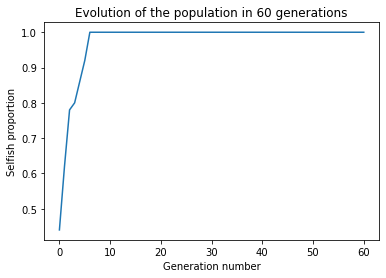

In [188]:
pop.run_simulation(60)

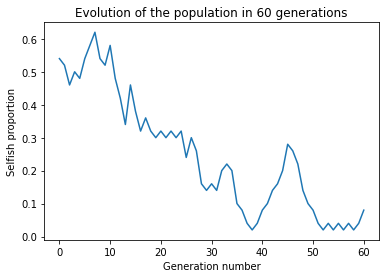

In [182]:
pop.plot_results()

In [183]:
pop.statistics

[(0, 0.54),
 (1, 0.52),
 (2, 0.46),
 (3, 0.5),
 (4, 0.48),
 (5, 0.54),
 (6, 0.58),
 (7, 0.62),
 (8, 0.54),
 (9, 0.52),
 (10, 0.58),
 (11, 0.48),
 (12, 0.42),
 (13, 0.34),
 (14, 0.46),
 (15, 0.38),
 (16, 0.32),
 (17, 0.36),
 (18, 0.32),
 (19, 0.3),
 (20, 0.32),
 (21, 0.3),
 (22, 0.32),
 (23, 0.3),
 (24, 0.32),
 (25, 0.24),
 (26, 0.3),
 (27, 0.26),
 (28, 0.16),
 (29, 0.14),
 (30, 0.16),
 (31, 0.14),
 (32, 0.2),
 (33, 0.22),
 (34, 0.2),
 (35, 0.1),
 (36, 0.08),
 (37, 0.04),
 (38, 0.02),
 (39, 0.04),
 (40, 0.08),
 (41, 0.1),
 (42, 0.14),
 (43, 0.16),
 (44, 0.2),
 (45, 0.28),
 (46, 0.26),
 (47, 0.22),
 (48, 0.14),
 (49, 0.1),
 (50, 0.08),
 (51, 0.04),
 (52, 0.02),
 (53, 0.04),
 (54, 0.02),
 (55, 0.04),
 (56, 0.02),
 (57, 0.04),
 (58, 0.02),
 (59, 0.04),
 (60, 0.08)]

In [99]:
pop.pop_size

20

In [189]:
def plot_simulation(n_rounds, step_size, acceptable_dist_from_stability = 0.1):
    simulations_stats_x = []
    simulations_stats_y = []
    pop_size = 50
    proportion_altruism = 0.5
    reproductive_fitness_table = {'selfish_selfish': (5,5), 'altruist_altruist': (11,11), 'altruist_selfish': (0,20),'selfish_altruist': (20,0) } 

    for altruist_iterator in range(int(1/step_size)+1):
        altruist_probability_to_engage_w_opposite_characteristic = altruist_iterator * 1/step_size

        for selfish_iterator in range(int(1/step_size)+1):
            selfish_probability_to_engage_w_opposite_characteristic = selfish_iterator * 1/step_size

           
            pop = Population(pop_size, proportion_altruism,altruist_probability_to_engage_w_opposite_characteristic, \
                                selfish_probability_to_engage_w_opposite_characteristic, reproductive_fitness_table )

            pop.run_simulation(n_rounds,show_plot = False)

            simulation_stat = pop.get_gen_stat()
            if simulation_stat[-1][1] >=0.5 - acceptable_dist_from_stability and simulation_stat[-1][1] <= 0.5 + acceptable_dist_from_stability:
                simulations_stats_x.append(altruist_probability_to_engage_w_opposite_characteristic)
                simulations_stats_y.append(selfish_probability_to_engage_w_opposite_characteristic)
    
    plt.scatter(simulations_stats_x,simulations_stats_y)

            

            

In [190]:
plot_simulation(40,0.1)